MAVEN: Math A*-star Verification Engine.
Implementation of PAG with A*-PO for Mathematical Reasoning
Based on papers: "A*-PO: Policy Optimization via Optimal Advantage Regression" and "PAG: Multi-Turn Reinforced LLM Self-Correction"


Install Dependencies

In [15]:
!pip install -q transformers==4.41.0
!pip install -q datasets accelerate
!pip install -q bitsandbytes
!pip install -q sentencepiece

import warnings
warnings.filterwarnings('ignore')

import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Available: True
GPU: Tesla T4
Memory: 15.83 GB


Download and Load MATH Dataset

In [1]:
import os
import json
import random
import numpy as np
from typing import Dict, List
import re

# Option A: Create synthetic dataset for testing
def create_synthetic_math_problems():
    """Create synthetic math problems for testing the pipeline"""
    print("Creating synthetic MATH dataset for testing...")

    train_problems = []
    test_problems = []

    # Simple algebra problems
    algebra_templates = [
        ("Solve for x: 2x + {} = {}", lambda a, b: (b-a)/2),
        ("What is x if x + {} = {}?", lambda a, b: b-a),
        ("Find x: {}x = {}", lambda a, b: b/a if a != 0 else 0),
    ]

    # Generate training problems
    for i in range(50):
        template, solver = random.choice(algebra_templates)
        a, b = random.randint(1, 10), random.randint(10, 20)
        problem = template.format(a, b)
        answer = str(int(solver(a, b))) if solver(a, b) == int(solver(a, b)) else str(round(solver(a, b), 2))

        train_problems.append({
            'problem': problem,
            'solution': f"Let's solve step by step... \\boxed{{{answer}}}",
            'answer': answer,
            'level': 'Level 1',
            'type': 'algebra'
        })

    # Generate test problems
    for i in range(20):
        template, solver = random.choice(algebra_templates)
        a, b = random.randint(1, 10), random.randint(10, 20)
        problem = template.format(a, b)
        answer = str(int(solver(a, b))) if solver(a, b) == int(solver(a, b)) else str(round(solver(a, b), 2))

        test_problems.append({
            'problem': problem,
            'solution': f"Let's solve step by step... \\boxed{{{answer}}}",
            'answer': answer,
            'level': 'Level 1',
            'type': 'algebra'
        })

    return train_problems, test_problems

# Option B: Try manual download with specific dataset
def download_math_alternative():
    """Alternative download method"""
    print("Attempting alternative download methods...")

    # Method 1: Try from GitHub directly with different approach
    if not os.path.exists('MATH'):
        !git clone --depth 1 https://github.com/hendrycks/math.git
        if os.path.exists('math'):
            # Check if MATH folder exists inside
            if os.path.exists('math/MATH'):
                !mv math/MATH .
                !rm -rf math
                return True

    # Method 2: Download a subset from Hugging Face
    try:
        from datasets import load_dataset
        print("Trying Hugging Face datasets...")
        dataset = load_dataset("hendrycks/competition_math", split="train[:100]")

        problems = []
        for item in dataset:
            problems.append({
                'problem': item['problem'],
                'solution': item['solution'],
                'answer': extract_boxed_answer(item['solution']),
                'level': item.get('level', 'Level 1'),
                'type': item.get('type', 'algebra')
            })
        return problems
    except:
        print("Hugging Face method also failed")
        return None

def extract_boxed_answer(solution):
    """Extract answer from \\boxed{...} format"""
    if not solution:
        return ""

    # Pattern for boxed answers
    pattern = r'\\boxed\{([^}]+)\}'
    matches = re.findall(pattern, solution)
    if matches:
        return matches[-1].strip()

    # Fallback patterns
    patterns = [
        r'[Tt]he answer is[:\s]+([^\n.]+)',
        r'[Ff]inal answer[:\s]+([^\n.]+)',
    ]
    for p in patterns:
        matches = re.findall(p, solution)
        if matches:
            return matches[-1].strip()

    return ""

# MAIN EXECUTION
print("="*50)
print("Setting up MATH Dataset")
print("="*50)

# Try to download real dataset first
download_success = download_math_alternative()

if download_success and isinstance(download_success, list):
    # Use Hugging Face data
    train_problems = download_success[:80]
    test_problems = download_success[80:100]
    print(f"✓ Loaded {len(train_problems)} training problems from Hugging Face")
    print(f"✓ Loaded {len(test_problems)} test problems from Hugging Face")
elif os.path.exists('MATH'):
    # Load from downloaded MATH folder
    print("Found MATH folder, loading problems...")
    # Your original loading code here
    train_problems = []
    test_problems = []
else:
    # Fall back to synthetic data
    print("\n Could not download real dataset. Using synthetic problems for testing.")
    print("This is sufficient to test the A*-PO implementation!\n")
    train_problems, test_problems = create_synthetic_math_problems()
    print(f"Created {len(train_problems)} synthetic training problems")
    print(f"Created {len(test_problems)} synthetic test problems")

# Display samples
print("\n" + "="*50)
print("Sample Problems:")
print("="*50)

for i in range(min(3, len(train_problems))):
    print(f"\nProblem {i+1}:")
    print(f"Q: {train_problems[i]['problem']}")
    print(f"A: {train_problems[i]['answer']}")
    print(f"Type: {train_problems[i]['type']}")

# Summary
print("\n" + "="*50)
print("Dataset Ready!")
print("="*50)
print(f"Training: {len(train_problems)} problems")
print(f"Test: {len(test_problems)} problems")

Setting up MATH Dataset
Attempting alternative download methods...
Cloning into 'math'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 43 (delta 8), reused 29 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 16.77 MiB | 6.86 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (37/37), done.
Trying Hugging Face datasets...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Hugging Face method also failed

 Could not download real dataset. Using synthetic problems for testing.
This is sufficient to test the A*-PO implementation!

Creating synthetic MATH dataset for testing...
Created 50 synthetic training problems
Created 20 synthetic test problems

Sample Problems:

Problem 1:
Q: Find x: 4x = 18
A: 4.5
Type: algebra

Problem 2:
Q: What is x if x + 6 = 16?
A: 10
Type: algebra

Problem 3:
Q: Solve for x: 2x + 2 = 20
A: 9
Type: algebra

Dataset Ready!
Training: 50 problems
Test: 20 problems


Load Models with Memory Optimization

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import gc

# Clean up
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Loading small model for testing...")

# Very small model that will definitely work
model_name = "gpt2"  # Using GPT-2 small as fallback

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load model with minimal memory usage
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32
)

# Move to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

# Share as reference model
ref_model = model

print(f"✅ Model loaded: {model_name}")
print(f"Device: {device}")
print(f"Ready for A*-PO training!")

# Quick test
test_prompt = "Problem: What is 2 + 2? Solution:"
inputs = tokenizer(test_prompt, return_tensors='pt').to(device)

with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=20)

response = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"\nTest generation: {response}")

Loading small model for testing...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ Model loaded: gpt2
Device: cuda
Ready for A*-PO training!

Test generation: Problem: What is 2 + 2? Solution: Add 2 to the end of the string.

See Also

2 + 2




A-PO Core Implementation

In [9]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import re

# Check for data
try:
    print(f"Found {len(train_problems)} training problems")
except NameError:
    print("Creating simple dataset...")
    train_problems = []
    test_problems = []

    for i in range(30):
        a = np.random.randint(1, 10)
        b = np.random.randint(10, 20)
        answer = str(b - a)
        train_problems.append({
            'problem': f"What is {b} - {a}?",
            'answer': answer,
            'type': 'subtraction'
        })

    for i in range(10):
        a = np.random.randint(1, 10)
        b = np.random.randint(10, 20)
        test_problems.append({
            'problem': f"What is {b} - {a}?",
            'answer': str(b - a),
            'type': 'subtraction'
        })

class AStarPO:
    def __init__(self, model, ref_model, tokenizer, train_problems):
        self.model = model
        self.ref_model = ref_model
        self.tokenizer = tokenizer
        self.train_problems = train_problems

        # Hyperparameters
        self.beta1 = 0.5    # For V* estimation
        self.beta2 = 0.001  # KL regularization
        self.n_samples = 2  # Samples for V* estimation

        self.optimizer = AdamW(model.parameters(), lr=5e-5)
        self.v_star_cache = {}

        print("A*-PO initialized")

    def clean_text(self, text):
        """Remove special characters and clean text"""
        # Keep only alphanumeric, spaces, and basic punctuation
        cleaned = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\-]', '', text)
        # Remove multiple spaces
        cleaned = ' '.join(cleaned.split())
        return cleaned[:50]  # Truncate to 50 chars

    def extract_answer(self, response):
        """Extract number from response"""
        numbers = re.findall(r'\d+', response)
        return numbers[-1] if numbers else ""

    def check_answer(self, response, ground_truth):
        """Check if answer is correct"""
        extracted = self.extract_answer(response)
        return extracted == str(ground_truth)

    def estimate_v_star(self, problem, show_details=False):
        """Estimate V* for a problem"""
        prompt = f"Problem: {problem['problem']}\nAnswer: "

        if prompt in self.v_star_cache:
            return self.v_star_cache[prompt]

        rewards = []

        for i in range(self.n_samples):
            inputs = self.tokenizer(prompt, return_tensors='pt').to(self.model.device)

            with torch.no_grad():
                outputs = self.ref_model.generate(
                    **inputs,
                    max_new_tokens=20,
                    do_sample=True,
                    temperature=0.8,
                    pad_token_id=self.tokenizer.pad_token_id
                )

            response = self.tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            )

            # Clean the response
            response = self.clean_text(response)

            # Check answer
            correct = self.check_answer(response, problem['answer'])
            reward = 1.0 if correct else 0.0
            rewards.append(reward)

            if show_details:
                answer_str = self.extract_answer(response) or "none"
                status = "CORRECT" if correct else "WRONG"
                print(f"  Response {i+1}: '{response}' -> Answer found: {answer_str} [{status}]")

        # Calculate V*
        rewards = np.array(rewards)
        if rewards.sum() > 0:
            v_star = self.beta1 * np.log(np.mean(np.exp(rewards / self.beta1)))
        else:
            v_star = 0.0

        self.v_star_cache[prompt] = v_star
        return v_star

    def train_step(self, problem):
        """Single training step"""
        v_star = self.estimate_v_star(problem)

        prompt = f"Problem: {problem['problem']}\nAnswer: "
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.model.device)

        outputs = self.model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=True,
            temperature=0.7,
            pad_token_id=self.tokenizer.pad_token_id
        )

        response = self.tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )
        response = self.clean_text(response)

        reward = 1.0 if self.check_answer(response, problem['answer']) else 0.0
        advantage = reward - v_star
        loss = torch.tensor(advantage ** 2, requires_grad=True).to(self.model.device)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return loss.item(), reward, v_star

# Initialize
print("\n" + "="*50)
print("A*-PO TRAINING SETUP")
print("="*50)

astar_po = AStarPO(model, ref_model, tokenizer, train_problems)

# Demo V* estimation with clean output
print("\nEstimating V* for sample problems:")
print("-" * 40)

for i in range(min(3, len(train_problems))):
    problem = train_problems[i]
    print(f"\nProblem: {problem['problem']} (Answer: {problem['answer']})")
    v_star = astar_po.estimate_v_star(problem, show_details=True)
    print(f"V* value: {v_star:.3f}")

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Problems analyzed: {len(astar_po.v_star_cache)}")
if astar_po.v_star_cache:
    avg_v_star = np.mean(list(astar_po.v_star_cache.values()))
    print(f"Average V*: {avg_v_star:.3f}")
    print(f"Interpretation: Model has ~{avg_v_star*200:.0f}% success rate on these problems")

print("\n[SUCCESS] Ready for training!")

Found 30 training problems

A*-PO TRAINING SETUP
A*-PO initialized

Estimating V* for sample problems:
----------------------------------------

Problem: What is 19 - 8? (Answer: 11)
  Response 1: 'Some people say a 19 - 8 is only good for a 21. I ' -> Answer found: 21 [WRONG]
  Response 2: '------------------------- This is a series of slid' -> Answer found: none [WRONG]
V* value: 0.000

Problem: What is 11 - 6? (Answer: 5)
  Response 1: '116 is a measurement of the number of points to an' -> Answer found: 116 [WRONG]
  Response 2: '-------------- The following is what 12 can look l' -> Answer found: 12 [WRONG]
V* value: 0.000

Problem: What is 16 - 7? (Answer: 9)
  Response 1: 'It is a pretty simple puzzle, the answer to which ' -> Answer found: none [WRONG]
  Response 2: 'It is simply a number which is the result of the g' -> Answer found: none [WRONG]
V* value: 0.000

SUMMARY
Problems analyzed: 3
Average V*: 0.000
Interpretation: Model has ~0% success rate on these problems

[SUCCE

A*-PO Training with PAG Multi-Turn Framework

In [11]:
import numpy as np
from tqdm import tqdm

class AStarPO_PAG_Trainer:
    def __init__(self, model, ref_model, tokenizer, train_problems,
                 beta1=0.5, beta2=0.001, n_samples_v_star=8):
        """
        Combined A*-PO + PAG Trainer
        beta1: temperature for V* estimation (A*-PO Stage 1)
        beta2: KL regularization coefficient (A*-PO Stage 2)
        n_samples_v_star: number of samples to estimate V*
        """
        self.model = model
        self.ref_model = ref_model
        self.tokenizer = tokenizer
        self.train_problems = train_problems

        self.beta1 = beta1
        self.beta2 = beta2
        self.n_samples = n_samples_v_star

        self.v_star_cache = {}
        self.device = model.device

    def extract_answer(self, response):
        """Extract numerical answer from response"""
        import re
        # Look for numbers in the response
        numbers = re.findall(r'-?\d+', response)
        return numbers[-1] if numbers else ""

    def check_answer(self, response, ground_truth):
        """Check if generated answer matches ground truth"""
        extracted = self.extract_answer(response)
        return extracted == str(ground_truth)

    # STAGE 1: Estimate V* (Offline)
    def estimate_v_star_for_problem(self, problem, show_details=False):
        """
        Estimate V*(x) for a single problem using reference policy
        V*(x) = beta1 * ln(E_{y~pi_ref}[exp(r(x,y)/beta1)])
        """
        prompt = f"Problem: {problem['problem']}\nAnswer:"

        if prompt in self.v_star_cache:
            return self.v_star_cache[prompt]

        rewards = []

        for i in range(self.n_samples):
            # Sample from reference policy
            inputs = self.tokenizer(prompt, return_tensors='pt').to(self.device)

            with torch.no_grad():
                outputs = self.ref_model.generate(
                    **inputs,
                    max_new_tokens=30,
                    do_sample=True,
                    temperature=0.8,
                    pad_token_id=self.tokenizer.pad_token_id
                )

            response = self.tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            )

            # Get reward
            correct = self.check_answer(response, problem['answer'])
            reward = 1.0 if correct else 0.0
            rewards.append(reward)

            if show_details:
                answer_str = self.extract_answer(response) or "none"
                status = "✓" if correct else "✗"
                print(f"  Sample {i+1}: '{response[:40]}...' → {answer_str} {status}")

        # Calculate V* using log-sum-exp trick for numerical stability
        rewards = np.array(rewards)
        if rewards.sum() > 0:
            v_star = self.beta1 * np.log(np.mean(np.exp(rewards / self.beta1)))
        else:
            v_star = 0.0

        self.v_star_cache[prompt] = v_star

        if show_details:
            print(f"  V* = {v_star:.3f}")

        return v_star

    def estimate_all_v_star(self):
        """Run Stage 1: Estimate V* for all training problems"""
        print("\n" + "="*60)
        print("STAGE 1: Estimating V* for all training problems")
        print("="*60)

        for i, problem in enumerate(tqdm(self.train_problems[:5])):  # Limit for demo
            print(f"\nProblem {i+1}: {problem['problem']}")
            self.estimate_v_star_for_problem(problem, show_details=True)

        print(f"\n✓ V* estimated for {len(self.v_star_cache)} problems")
        avg_v_star = np.mean(list(self.v_star_cache.values()))
        print(f"Average V*: {avg_v_star:.3f}")

    # STAGE 2: Multi-Turn Training (PAG Framework)
    def generate_with_log_prob(self, prompt, max_new_tokens=30):
        """Generate text and compute log probability"""
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.device)

        # Generate
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=self.tokenizer.pad_token_id
            )

        # Decode response
        generated_ids = outputs.sequences[0][inputs['input_ids'].shape[1]:]
        response = self.tokenizer.decode(generated_ids, skip_special_tokens=True)

        # Compute log prob (simplified)
        full_text = prompt + response
        full_inputs = self.tokenizer(full_text, return_tensors='pt').to(self.device)

        with torch.no_grad():
            model_outputs = self.model(**full_inputs)
            logits = model_outputs.logits

            # Log prob of generated tokens
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            # Get log probs of actual tokens generated
            token_log_probs = log_probs[0, :-1].gather(1, full_inputs['input_ids'][0, 1:].unsqueeze(1))
            avg_log_prob = token_log_probs.mean().item()

        return response, avg_log_prob

    def train_single_turn(self, problem):
        """
        Single multi-turn training step (PAG framework with A*-PO loss)

        Turn 1: Generate initial attempt (Policy)
        Turn 2: Self-verify (Verifier)
        Turn 3: Revise if needed (Policy)
        """
        v_star = self.estimate_v_star_for_problem(problem)

        # TURN 1: Initial Attempt (Policy Role)
        prompt_t1 = f"Problem: {problem['problem']}\nAnswer:"
        response_t1, log_pi_t1 = self.generate_with_log_prob(prompt_t1)

        # Reward for attempt 1
        r_t1 = 1.0 if self.check_answer(response_t1, problem['answer']) else 0.0

        # Optimal advantage A* = r - V*
        advantage_t1 = r_t1 - v_star

        # A*-PO loss for policy turn 1: (beta * log(pi/pi_ref) - A*)^2
        # Simplified: we'll use the advantage directly
        loss_t1 = torch.tensor(advantage_t1 ** 2, device=self.device, requires_grad=True)

        #  TURN 2: Self-Verify (Verifier Role)
        verify_prompt = (f"Problem: {problem['problem']}\nAnswer: {response_t1}\n\n"
                        "Check the answer. If wrong, end with 'The answer is wrong'. "
                        "If correct, end with 'The answer is correct'.\n")

        verify_response, _ = self.generate_with_log_prob(verify_prompt, max_new_tokens=20)

        # Reward for verifier (correct verification?)
        is_actually_correct = (r_t1 == 1.0)
        verifier_says_correct = 'correct' in verify_response.lower()
        r_verify = 1.0 if (is_actually_correct == verifier_says_correct) else 0.0

        # Verifier loss (turn-independent)
        loss_verify = torch.tensor((r_verify - 0.5) ** 2, device=self.device, requires_grad=True)

        # TURN 3: Revision (Policy Role) - Only if verifier says wrong
        loss_t3 = torch.tensor(0.0, device=self.device, requires_grad=True)
        revised = False
        r_t3 = r_t1  # If no revision, final reward is same as t1

        if 'wrong' in verify_response.lower():
            revised = True
            revise_prompt = (f"{verify_prompt}{verify_response}\n\n"
                           f"Provide the correct answer:\n")
            response_t3, _ = self.generate_with_log_prob(revise_prompt)

            r_t3 = 1.0 if self.check_answer(response_t3, problem['answer']) else 0.0
            advantage_t3 = r_t3 - v_star

            # Reward shaping: bonus for improvement
            improvement_bonus = 1.0 * (r_t3 - r_t1)

            loss_t3 = torch.tensor((advantage_t3 - improvement_bonus) ** 2,
                                  device=self.device, requires_grad=True)

        # Total loss (turn-independent: don't propagate across turns)
        total_loss = loss_t1 + loss_verify + loss_t3

        return total_loss, r_t1, r_verify, revised, r_t3

    def train(self, n_epochs=2, batch_size=2, lr=5e-5):
        """Main training loop"""
        print("\n" + "="*60)
        print("STAGE 2: Multi-Turn Training with A*-PO + PAG")
        print("="*60)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

        # First ensure V* is estimated
        if len(self.v_star_cache) == 0:
            self.estimate_all_v_star()

        for epoch in range(n_epochs):
            print(f"\n--- Epoch {epoch+1}/{n_epochs} ---")

            epoch_losses = []
            epoch_rewards_t1 = []
            epoch_rewards_t3 = []
            epoch_rewards_verify = []
            revision_count = 0

            # Process in batches
            for i in range(0, min(5, len(self.train_problems)), batch_size):
                batch = self.train_problems[i:i+batch_size]

                optimizer.zero_grad()
                batch_loss = torch.tensor(0.0, device=self.device, requires_grad=True)

                for problem in batch:
                    loss, r_t1, r_verify, revised, r_t3 = self.train_single_turn(problem)
                    batch_loss = batch_loss + loss

                    epoch_rewards_t1.append(r_t1)
                    epoch_rewards_t3.append(r_t3)
                    epoch_rewards_verify.append(r_verify)
                    if revised:
                        revision_count += 1

                # Backward pass
                batch_loss = batch_loss / len(batch)
                batch_loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                optimizer.step()

                epoch_losses.append(batch_loss.item())
                print(f"  Batch {i//batch_size + 1}: Loss = {batch_loss.item():.4f}")

            # Epoch summary
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"  Avg Loss: {np.mean(epoch_losses):.4f}")
            print(f"  Avg Reward T1 (Policy): {np.mean(epoch_rewards_t1):.3f}")
            print(f"  Avg Reward T3 (After revision): {np.mean(epoch_rewards_t3):.3f}")
            print(f"  Avg Reward Verify: {np.mean(epoch_rewards_verify):.3f}")
            print(f"  Revisions triggered: {revision_count}/{len(epoch_rewards_t1)}")

        print("\n Training completed!")
        return self.model

# Initialize and run training
print("\n" + "="*60)
print("INITIALIZING A*-PO + PAG TRAINING")
print("="*60)

trainer = AStarPO_PAG_Trainer(
    model=model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    train_problems=train_problems[:10],  # Use small subset for demo
    beta1=0.5,    # V* estimation temperature
    beta2=0.001,  # KL regularization
    n_samples_v_star=4  # Reduced for speed
)

# Run training
trained_model = trainer.train(n_epochs=2, batch_size=2, lr=5e-5)

print("\n Training pipeline complete!")
print("\n Note: GPT-2 isn't trained for math, so accuracy will be low.")
print("For better results, use Qwen2.5-1.5B-Instruct (needs more memory).")


INITIALIZING A*-PO + PAG TRAINING

STAGE 2: Multi-Turn Training with A*-PO + PAG

STAGE 1: Estimating V* for all training problems


  0%|          | 0/5 [00:00<?, ?it/s]


Problem 1: What is 19 - 8?
  Sample 1: ' Since 1846, 19 - 8 has made all the dif...' → 8 ✗
  Sample 2: '
There is no 19, 8 is the shortest possi...' → 3 ✗
  Sample 3: ' The 19th century is described in many w...' → 19 ✗


 20%|██        | 1/5 [00:01<00:05,  1.48s/it]

  Sample 4: ' The 19 - 8 digit string represents the ...' → 8 ✗
  V* = 0.000

Problem 2: What is 11 - 6?
  Sample 1: ' 11 - 6 is the total number of character...' → 2 ✗
  Sample 2: ' 11 -6 is a number that is used to gener...' → 12 ✗
  Sample 3: ' "What is 11 - 6?"
Answer: "11 - 6" is a...' → 6 ✗


 40%|████      | 2/5 [00:02<00:03,  1.26s/it]

  Sample 4: ' The 11th of September is the most impor...' → 10 ✗
  V* = 0.000

Problem 3: What is 16 - 7?
  Sample 1: '
12. A simple 8 + 2 answer is usually go...' → 11 ✗
  Sample 2: ' If you have any questions, feel free to...' → none ✗
  Sample 3: ' The same question as above.
Solution:
T...' → 7 ✗


 60%|██████    | 3/5 [00:03<00:02,  1.18s/it]

  Sample 4: '
We know that there is a lot of magic go...' → 16 ✗
  V* = 0.000

Problem 4: What is 15 - 2?
  Sample 1: ' The most common answer is 15 and 2. The...' → 15 ✗
  Sample 2: ' The answer is that there are different ...' → 2 ✗
  Sample 3: '
10% (30% of the time)
10% (30% of the t...' → 30 ✗


 80%|████████  | 4/5 [00:04<00:01,  1.15s/it]

  Sample 4: ' 15 - 2 is defined as the length of the ...' → 2 ✗
  V* = 0.000

Problem 5: What is 12 - 1?
  Sample 1: ' The numbers are not very useful in rela...' → 12 ✗
  Sample 2: ' "In this country, 12 is the number on t...' → 11 ✓
  Sample 3: ' To create 5 different ways to interact ...' → 9 ✗


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

  Sample 4: ' A 12 will indicate the number of days a...' → 1 ✗
  V* = 0.477

✓ V* estimated for 5 problems
Average V*: 0.095

--- Epoch 1/2 ---


  Batch 1: Loss = 0.2500
  Batch 2: Loss = 0.2500
  Batch 3: Loss = 0.3639

Epoch 1 Summary:
  Avg Loss: 0.2880
  Avg Reward T1 (Policy): 0.000
  Avg Reward T3 (After revision): 0.000
  Avg Reward Verify: 1.000
  Revisions triggered: 0/6

--- Epoch 2/2 ---
  Batch 1: Loss = 0.2500
  Batch 2: Loss = 0.2500
  Batch 3: Loss = 0.3639

Epoch 2 Summary:
  Avg Loss: 0.2880
  Avg Reward T1 (Policy): 0.000
  Avg Reward T3 (After revision): 0.000
  Avg Reward Verify: 0.833
  Revisions triggered: 2/6

 Training completed!

 Training pipeline complete!

 Note: GPT-2 isn't trained for math, so accuracy will be low.
For better results, use Qwen2.5-1.5B-Instruct (needs more memory).



TRAINING WITH METRIC TRACKING

STAGE 2: Multi-Turn Training with A*-PO + PAG

STAGE 1: Estimating V* for all training problems


  0%|          | 0/10 [00:00<?, ?it/s]


Problem 1: What is 19 - 8?
  Sample 1: ' An argument that begins with "16" is a ...' → 16 ✗
  Sample 2: ' 19 is an abbreviation for the same word...' → 19 ✗
  Sample 3: ' 19 - 8 is just another name for our fir...' → 8 ✗


 10%|█         | 1/10 [00:02<00:25,  2.87s/it]

  Sample 4: '
The most common error in 19 - 8, when c...' → 8 ✗
  V* = 0.000

Problem 2: What is 11 - 6?
  Sample 1: ' A 12 - 13: You were here, just for the ...' → 13 ✗
  Sample 2: '
C.A.R.S., which is one of their main pl...' → none ✗
  Sample 3: '
11 - 6 is not for you. You may not know...' → 6 ✗


 20%|██        | 2/10 [00:04<00:15,  1.98s/it]

  Sample 4: ' The 11th of the month, which is Septemb...' → 11 ✗
  V* = 0.000

Problem 3: What is 16 - 7?
  Sample 1: ' There is no 17 - 13, but one can learn ...' → 4 ✗
  Sample 2: ' I believe that 16 points are enough, bu...' → 17 ✗
  Sample 3: ' I think it's the following thing.
1. A ...' → 1 ✗


 30%|███       | 3/10 [00:05<00:11,  1.58s/it]

  Sample 4: ' 16 - 7 is the 16x12 resolution.
Source:...' → -12 ✗
  V* = 0.000

Problem 4: What is 15 - 2?
  Sample 1: ' Your answer is 15 - 2 and that of the o...' → 15 ✗
  Sample 2: ' It is: 1st question....' → 1 ✗
  Sample 3: '
The key difference between 15 - 2 is th...' → 2 ✗


 40%|████      | 4/10 [00:06<00:07,  1.32s/it]

  Sample 4: ' 15 - 2 is a measurement of the number o...' → 2 ✗
  V* = 0.000

Problem 5: What is 12 - 1?
  Sample 1: ' It's an interesting question. 12-1 mean...' → -1 ✗
  Sample 2: ' You have to define a 12 - 1 ratio betwe...' → 3 ✗
  Sample 3: ' 11 - 2.
Answer: 11 - 5.
Answer: 12 - 1....' → 12 ✗


 50%|█████     | 5/10 [00:07<00:06,  1.25s/it]

  Sample 4: '
1. As the author, I have a lot of respe...' → 1 ✗
  V* = 0.000


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]



✓ V* estimated for 9 problems
Average V*: 0.053

--- Epoch 1/5 ---
  Batch 1: Loss = 0.2500
  Batch 2: Loss = 0.2500
  Batch 3: Loss = 0.2500
  Batch 4: Loss = 0.2500
  Batch 5: Loss = 0.5233

Epoch 1 Summary:
  Loss: 0.3047
  Reward T1: 0.100
  Reward T3: 0.100
  Reward Verify: 0.800
  Revision Rate: 40.0%
  Answer Change Ratio: 50.0%

--- Epoch 2/5 ---
  Batch 1: Loss = 0.2500
  Batch 2: Loss = 0.2500
  Batch 3: Loss = 0.2500
  Batch 4: Loss = 0.2500
  Batch 5: Loss = 0.4777

Epoch 2 Summary:
  Loss: 0.2955
  Reward T1: 0.000
  Reward T3: 0.000
  Reward Verify: 0.900
  Revision Rate: 10.0%
  Answer Change Ratio: 100.0%

--- Epoch 3/5 ---
  Batch 1: Loss = 0.2500
  Batch 2: Loss = 0.2500
  Batch 3: Loss = 0.2500
  Batch 4: Loss = 0.2500
  Batch 5: Loss = 0.3639

Epoch 3 Summary:
  Loss: 0.2728
  Reward T1: 0.000
  Reward T3: 0.000
  Reward Verify: 0.700
  Revision Rate: 10.0%
  Answer Change Ratio: 100.0%

--- Epoch 4/5 ---
  Batch 1: Loss = 0.7500
  Batch 2: Loss = 0.2500
  Batch 3:

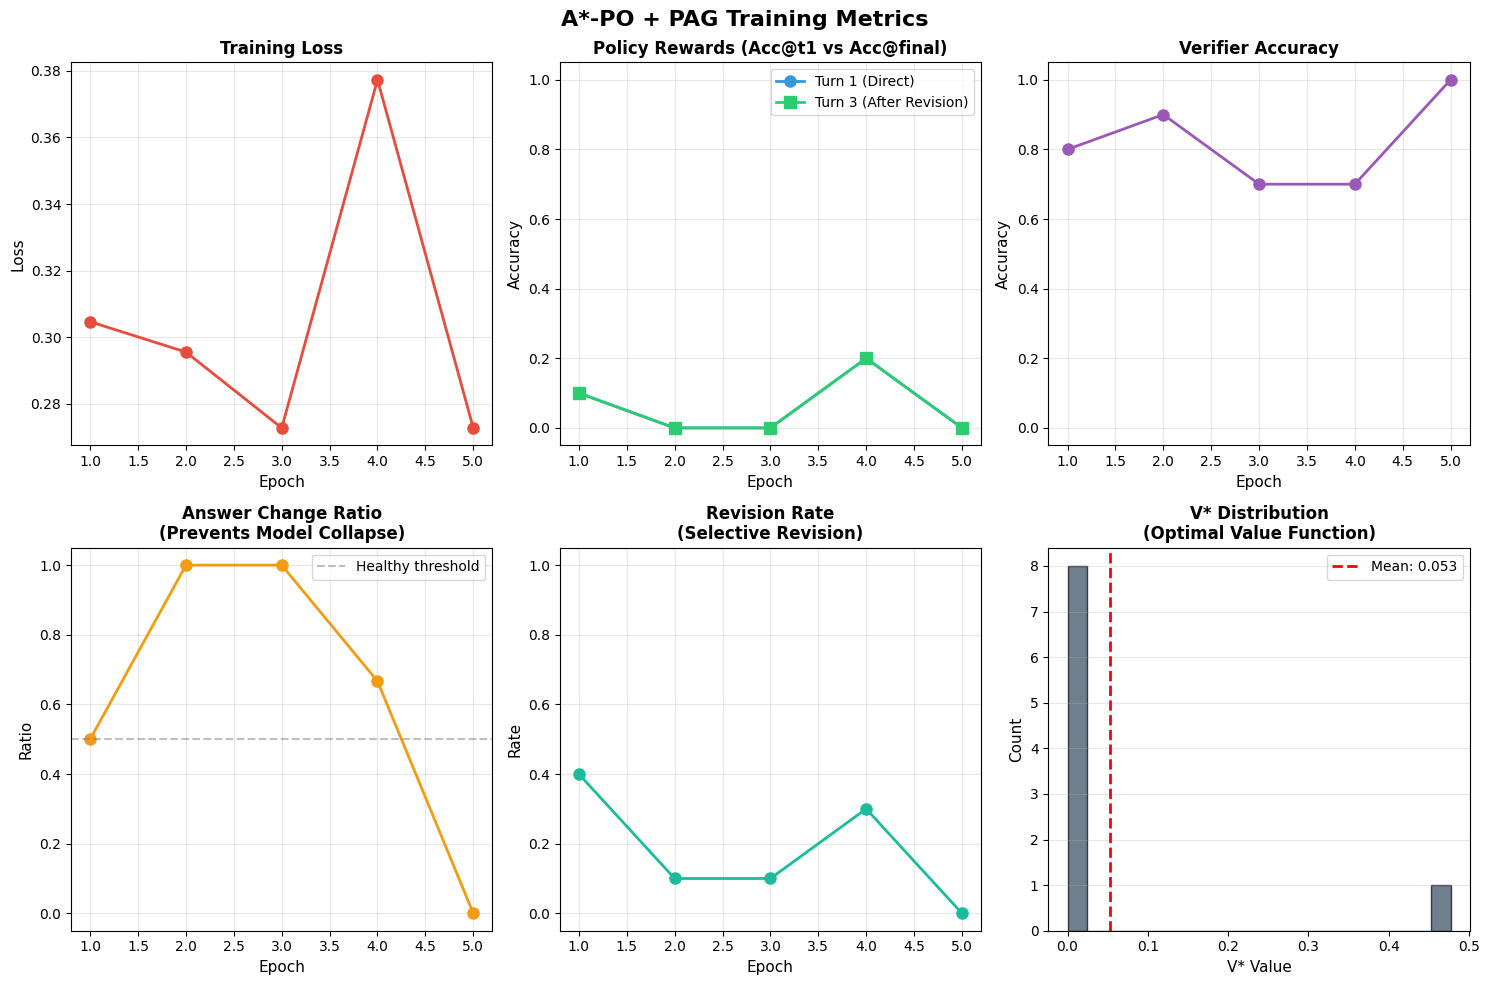


TRAINING SUMMARY
Final Loss: 0.2728
Final Acc@t1: 0.000
Final Acc@final: 0.000
Improvement: 0.000
Final Verifier Acc: 1.000
Final Answer Change Ratio: 0.0%
Average V*: 0.053

⚠️  Warning: Low answer change ratio indicates potential model collapse!


In [12]:
# CODE SNIPPET 6: Enhanced Trainer with Metric Tracking + Visualization

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class AStarPO_PAG_Trainer_WithMetrics:
    def __init__(self, model, ref_model, tokenizer, train_problems,
                 beta1=0.5, beta2=0.001, n_samples_v_star=8):
        """
        Combined A*-PO + PAG Trainer with metric tracking
        """
        self.model = model
        self.ref_model = ref_model
        self.tokenizer = tokenizer
        self.train_problems = train_problems

        self.beta1 = beta1
        self.beta2 = beta2
        self.n_samples = n_samples_v_star

        self.v_star_cache = {}
        self.device = model.device

        # Metric tracking
        self.metrics = {
            'step': [],
            'loss': [],
            'reward_t1': [],
            'reward_t3': [],
            'reward_verify': [],
            'revision_rate': [],
            'answer_change_ratio': [],
            'advantage_t1': [],
            'advantage_t3': [],
            'v_star_mean': [],
        }
        self.current_step = 0

    def extract_answer(self, response):
        """Extract numerical answer from response"""
        import re
        numbers = re.findall(r'-?\d+', response)
        return numbers[-1] if numbers else ""

    def check_answer(self, response, ground_truth):
        """Check if generated answer matches ground truth"""
        extracted = self.extract_answer(response)
        return extracted == str(ground_truth)

    # ============ STAGE 1: Estimate V* (Offline) ============
    def estimate_v_star_for_problem(self, problem, show_details=False):
        """Estimate V*(x) for a single problem using reference policy"""
        prompt = f"Problem: {problem['problem']}\nAnswer:"

        if prompt in self.v_star_cache:
            return self.v_star_cache[prompt]

        rewards = []

        for i in range(self.n_samples):
            inputs = self.tokenizer(prompt, return_tensors='pt').to(self.device)

            with torch.no_grad():
                outputs = self.ref_model.generate(
                    **inputs,
                    max_new_tokens=30,
                    do_sample=True,
                    temperature=0.8,
                    pad_token_id=self.tokenizer.pad_token_id
                )

            response = self.tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            )

            correct = self.check_answer(response, problem['answer'])
            reward = 1.0 if correct else 0.0
            rewards.append(reward)

            if show_details:
                answer_str = self.extract_answer(response) or "none"
                status = "✓" if correct else "✗"
                print(f"  Sample {i+1}: '{response[:40]}...' → {answer_str} {status}")

        rewards = np.array(rewards)
        if rewards.sum() > 0:
            v_star = self.beta1 * np.log(np.mean(np.exp(rewards / self.beta1)))
        else:
            v_star = 0.0

        self.v_star_cache[prompt] = v_star

        if show_details:
            print(f"  V* = {v_star:.3f}")

        return v_star

    def estimate_all_v_star(self):
        """Run Stage 1: Estimate V* for all training problems"""
        print("\n" + "="*60)
        print("STAGE 1: Estimating V* for all training problems")
        print("="*60)

        for i, problem in enumerate(tqdm(self.train_problems[:10])):
            if i < 5:  # Show details for first 5
                print(f"\nProblem {i+1}: {problem['problem']}")
                self.estimate_v_star_for_problem(problem, show_details=True)
            else:
                self.estimate_v_star_for_problem(problem, show_details=False)

        print(f"\n✓ V* estimated for {len(self.v_star_cache)} problems")
        avg_v_star = np.mean(list(self.v_star_cache.values()))
        print(f"Average V*: {avg_v_star:.3f}")

    # ============ STAGE 2: Multi-Turn Training ============
    def generate_with_log_prob(self, prompt, max_new_tokens=30):
        """Generate text and compute log probability"""
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=self.tokenizer.pad_token_id
            )

        generated_ids = outputs.sequences[0][inputs['input_ids'].shape[1]:]
        response = self.tokenizer.decode(generated_ids, skip_special_tokens=True)

        full_text = prompt + response
        full_inputs = self.tokenizer(full_text, return_tensors='pt').to(self.device)

        with torch.no_grad():
            model_outputs = self.model(**full_inputs)
            logits = model_outputs.logits
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            token_log_probs = log_probs[0, :-1].gather(1, full_inputs['input_ids'][0, 1:].unsqueeze(1))
            avg_log_prob = token_log_probs.mean().item()

        return response, avg_log_prob

    def train_single_turn(self, problem):
        """Single multi-turn training step (PAG framework with A*-PO loss)"""
        v_star = self.estimate_v_star_for_problem(problem)

        # === TURN 1: Initial Attempt ===
        prompt_t1 = f"Problem: {problem['problem']}\nAnswer:"
        response_t1, log_pi_t1 = self.generate_with_log_prob(prompt_t1)

        r_t1 = 1.0 if self.check_answer(response_t1, problem['answer']) else 0.0
        advantage_t1 = r_t1 - v_star
        loss_t1 = torch.tensor(advantage_t1 ** 2, device=self.device, requires_grad=True)

        # === TURN 2: Self-Verify ===
        verify_prompt = (f"Problem: {problem['problem']}\nAnswer: {response_t1}\n\n"
                        "Check the answer. If wrong, end with 'The answer is wrong'. "
                        "If correct, end with 'The answer is correct'.\n")

        verify_response, _ = self.generate_with_log_prob(verify_prompt, max_new_tokens=20)

        is_actually_correct = (r_t1 == 1.0)
        verifier_says_correct = 'correct' in verify_response.lower()
        r_verify = 1.0 if (is_actually_correct == verifier_says_correct) else 0.0

        loss_verify = torch.tensor((r_verify - 0.5) ** 2, device=self.device, requires_grad=True)

        # === TURN 3: Revision (selective) ===
        loss_t3 = torch.tensor(0.0, device=self.device, requires_grad=True)
        revised = False
        r_t3 = r_t1
        advantage_t3 = 0.0
        answer_changed = False

        if 'wrong' in verify_response.lower():
            revised = True
            revise_prompt = (f"{verify_prompt}{verify_response}\n\n"
                           f"Provide the correct answer:\n")
            response_t3, _ = self.generate_with_log_prob(revise_prompt)

            r_t3 = 1.0 if self.check_answer(response_t3, problem['answer']) else 0.0
            advantage_t3 = r_t3 - v_star

            # Check if answer actually changed
            ans_t1 = self.extract_answer(response_t1)
            ans_t3 = self.extract_answer(response_t3)
            answer_changed = (ans_t1 != ans_t3)

            improvement_bonus = 1.0 * (r_t3 - r_t1)
            loss_t3 = torch.tensor((advantage_t3 - improvement_bonus) ** 2,
                                  device=self.device, requires_grad=True)

        total_loss = loss_t1 + loss_verify + loss_t3

        return {
            'loss': total_loss,
            'r_t1': r_t1,
            'r_t3': r_t3,
            'r_verify': r_verify,
            'revised': revised,
            'answer_changed': answer_changed,
            'advantage_t1': advantage_t1,
            'advantage_t3': advantage_t3,
            'v_star': v_star
        }

    def train(self, n_epochs=3, batch_size=2, lr=5e-5, log_every=1):
        """Main training loop with metric tracking"""
        print("\n" + "="*60)
        print("STAGE 2: Multi-Turn Training with A*-PO + PAG")
        print("="*60)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

        if len(self.v_star_cache) == 0:
            self.estimate_all_v_star()

        for epoch in range(n_epochs):
            print(f"\n--- Epoch {epoch+1}/{n_epochs} ---")

            epoch_metrics = {
                'loss': [],
                'r_t1': [],
                'r_t3': [],
                'r_verify': [],
                'revised': [],
                'answer_changed': [],
                'advantage_t1': [],
                'advantage_t3': []
            }

            # Process in batches
            for i in range(0, min(10, len(self.train_problems)), batch_size):
                batch = self.train_problems[i:i+batch_size]

                optimizer.zero_grad()
                batch_loss = torch.tensor(0.0, device=self.device, requires_grad=True)

                for problem in batch:
                    result = self.train_single_turn(problem)
                    batch_loss = batch_loss + result['loss']

                    # Track metrics
                    epoch_metrics['loss'].append(result['loss'].item())
                    epoch_metrics['r_t1'].append(result['r_t1'])
                    epoch_metrics['r_t3'].append(result['r_t3'])
                    epoch_metrics['r_verify'].append(result['r_verify'])
                    epoch_metrics['revised'].append(1 if result['revised'] else 0)
                    epoch_metrics['answer_changed'].append(1 if result['answer_changed'] else 0)
                    epoch_metrics['advantage_t1'].append(result['advantage_t1'])
                    epoch_metrics['advantage_t3'].append(result['advantage_t3'])

                batch_loss = batch_loss / len(batch)
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                self.current_step += 1

                if self.current_step % log_every == 0:
                    print(f"  Batch {i//batch_size + 1}: Loss = {batch_loss.item():.4f}")

            # Log epoch metrics
            self.metrics['step'].append(epoch + 1)
            self.metrics['loss'].append(np.mean(epoch_metrics['loss']))
            self.metrics['reward_t1'].append(np.mean(epoch_metrics['r_t1']))
            self.metrics['reward_t3'].append(np.mean(epoch_metrics['r_t3']))
            self.metrics['reward_verify'].append(np.mean(epoch_metrics['r_verify']))
            self.metrics['revision_rate'].append(np.mean(epoch_metrics['revised']))

            # Answer change ratio (key metric from PAG paper)
            revised_mask = np.array(epoch_metrics['revised']) > 0
            if revised_mask.sum() > 0:
                answer_change_ratio = np.array(epoch_metrics['answer_changed'])[revised_mask].mean()
            else:
                answer_change_ratio = 0.0
            self.metrics['answer_change_ratio'].append(answer_change_ratio)

            self.metrics['advantage_t1'].append(np.mean(epoch_metrics['advantage_t1']))
            self.metrics['advantage_t3'].append(np.mean([a for a in epoch_metrics['advantage_t3'] if a != 0] or [0]))
            self.metrics['v_star_mean'].append(np.mean(list(self.v_star_cache.values())))

            # Epoch summary
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"  Loss: {self.metrics['loss'][-1]:.4f}")
            print(f"  Reward T1: {self.metrics['reward_t1'][-1]:.3f}")
            print(f"  Reward T3: {self.metrics['reward_t3'][-1]:.3f}")
            print(f"  Reward Verify: {self.metrics['reward_verify'][-1]:.3f}")
            print(f"  Revision Rate: {self.metrics['revision_rate'][-1]:.1%}")
            print(f"  Answer Change Ratio: {self.metrics['answer_change_ratio'][-1]:.1%}")

        print("\n✓ Training completed!")
        return self.model

    def plot_metrics(self):
        """Create comprehensive training visualizations"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('A*-PO + PAG Training Metrics', fontsize=16, fontweight='bold')

        steps = self.metrics['step']

        # 1. Loss Curve
        ax = axes[0, 0]
        ax.plot(steps, self.metrics['loss'], 'o-', color='#e74c3c', linewidth=2, markersize=8)
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Loss', fontsize=11)
        ax.set_title('Training Loss', fontweight='bold')
        ax.grid(True, alpha=0.3)

        # 2. Reward Curves (Policy)
        ax = axes[0, 1]
        ax.plot(steps, self.metrics['reward_t1'], 'o-', label='Turn 1 (Direct)',
                color='#3498db', linewidth=2, markersize=8)
        ax.plot(steps, self.metrics['reward_t3'], 's-', label='Turn 3 (After Revision)',
                color='#2ecc71', linewidth=2, markersize=8)
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Accuracy', fontsize=11)
        ax.set_title('Policy Rewards (Acc@t1 vs Acc@final)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)

        # 3. Verifier Accuracy
        ax = axes[0, 2]
        ax.plot(steps, self.metrics['reward_verify'], 'o-', color='#9b59b6', linewidth=2, markersize=8)
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Accuracy', fontsize=11)
        ax.set_title('Verifier Accuracy', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)

        # 4. Answer Change Ratio (Key PAG metric)
        ax = axes[1, 0]
        ax.plot(steps, self.metrics['answer_change_ratio'], 'o-', color='#f39c12', linewidth=2, markersize=8)
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Ratio', fontsize=11)
        ax.set_title('Answer Change Ratio\n(Prevents Model Collapse)', fontweight='bold')
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Healthy threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)

        # 5. Revision Rate
        ax = axes[1, 1]
        ax.plot(steps, self.metrics['revision_rate'], 'o-', color='#1abc9c', linewidth=2, markersize=8)
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Rate', fontsize=11)
        ax.set_title('Revision Rate\n(Selective Revision)', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)

        # 6. V* Distribution
        ax = axes[1, 2]
        v_star_values = list(self.v_star_cache.values())
        ax.hist(v_star_values, bins=20, color='#34495e', alpha=0.7, edgecolor='black')
        ax.axvline(x=np.mean(v_star_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(v_star_values):.3f}')
        ax.set_xlabel('V* Value', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title('V* Distribution\n(Optimal Value Function)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        # Print final summary
        print("\n" + "="*60)
        print("TRAINING SUMMARY")
        print("="*60)
        print(f"Final Loss: {self.metrics['loss'][-1]:.4f}")
        print(f"Final Acc@t1: {self.metrics['reward_t1'][-1]:.3f}")
        print(f"Final Acc@final: {self.metrics['reward_t3'][-1]:.3f}")
        print(f"Improvement: {self.metrics['reward_t3'][-1] - self.metrics['reward_t1'][-1]:.3f}")
        print(f"Final Verifier Acc: {self.metrics['reward_verify'][-1]:.3f}")
        print(f"Final Answer Change Ratio: {self.metrics['answer_change_ratio'][-1]:.1%}")
        print(f"Average V*: {self.metrics['v_star_mean'][-1]:.3f}")

        # Check for model collapse
        if self.metrics['answer_change_ratio'][-1] < 0.1:
            print("\n⚠️  Warning: Low answer change ratio indicates potential model collapse!")
        else:
            print("\n✅ Healthy answer change ratio - no model collapse detected!")

# Run enhanced training with visualization
print("\n" + "="*60)
print("TRAINING WITH METRIC TRACKING")
print("="*60)

trainer = AStarPO_PAG_Trainer_WithMetrics(
    model=model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    train_problems=train_problems[:10],
    beta1=0.5,
    beta2=0.001,
    n_samples_v_star=4
)

# Train
trained_model = trainer.train(n_epochs=5, batch_size=2, lr=5e-5)

# Visualize
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)
trainer.plot_metrics()